# Task 1 Graph Cut

In [1]:
import ipywidgets as widgets

file = open("./images/graph.png", "rb")
image = file.read()
widgets.Image(
    value=image,
    format='png',
    width=300,
    height=50,
)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x020\x00\x00\x02;\x08\x06\x00\x00\x00\xf26\xa1\xac\x…

In [2]:
import numpy as np
import cv2

W = np.zeros((8, 8))
W[0, 1] = 1
W[0, 2] = 0.2
W[0, 3] = 1

W[1, 2] = 0.1
W[1, 4] = 1

W[2, 3] = 1
W[2, 5] = 1
W[2, 6] = 0.3

W[3, 5] = 0.1

W[4, 6] = 1
W[4, 7] = 1

W[5, 6] = 1

W[6, 7] = 1

W += W.T
D = np.diag(np.sum(W, axis=1))

Compute the second smallest eigenvector $y$ of this generalized eigenvalue problem:

$(D - W) y = \lambda D y$


Hint: We can calculate $D^{-\frac{1}{2}} (D - W) D^{-\frac{1}{2}} z = \lambda z$ instead.

Then $z = D^{\frac{1}{2}} y$

So $y = (D^{\frac{1}{2}})^{-1} z$

In [32]:
L = D - W
A = np.matmul(np.linalg.inv(np.sqrt(D)), L)
A = np.matmul(A, np.linalg.inv(np.sqrt(D)))
_, eigvalues, eigvectors = cv2.eigen(A)

ind = A.shape[0] - 2
z = eigvectors[ind]

y = np.matmul(np.linalg.inv(np.sqrt(D)), z)
assert np.allclose(np.matmul(np.linalg.inv(np.sqrt(D)), z),  y)
assert np.allclose(np.matmul(L, y), eigvalues[ind] * np.matmul(D, y))
print('y:\n {}'.format(y))

y:
 [-0.28094263 -0.05184031 -0.19699005 -0.33291301  0.22593358 -0.01834545
  0.20384337  0.31313573]


In [24]:
inds = np.where(y > 0)[0]
print('Elements in cluster 1:')
for ind in inds:
    print(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'][ind])
print()

inds = np.where(y < 0)[0]
print('Elements in cluster 2:')
for ind in inds:
    print(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'][ind])

Elements in cluster 1:
E
G
H

Elements in cluster 2:
A
B
C
D
F


In [30]:
import ipywidgets as widgets

file = open("./images/graph.png", "rb")
image = file.read()
widgets.Image(
    value=image,
    format='png',
    width=300,
    height=50,
)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x020\x00\x00\x02;\x08\x06\x00\x00\x00\xf26\xa1\xac\x…

In [31]:
cost = 2.3 / (2.2 + 2.1 + 2.6 + 2.1 + 2.1) + 2.3 / (3 + 3.3 + 2) 
print('The cost of NCut is: {:.3f}'.format(cost))

The cost of NCut is: 0.484


# Solution for task 2

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_snake(ax, V, fill='green', line='red', alpha=1, with_txt=False):
    """ plots the snake onto a sub-plot
    :param ax: subplot (fig.add_subplot(abc))
    :param V: point locations ( [ (x0, y0), (x1, y1), ... (xn, yn)]
    :param fill: point color
    :param line: line color
    :param alpha: [0 .. 1]
    :param with_txt: if True plot numbers as well
    :return:
    """
    V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.plot(V_plt[:, 0], V_plt[:, 1], color=line, alpha=alpha)
    ax.scatter(V[:, 0], V[:, 1], color=fill, edgecolors='black', linewidth=2, s=50, alpha=alpha)
    if with_txt:
        for i, (x, y) in enumerate(V):
            ax.text(x, y, str(i))


def load_data(fpath, radius):
    """
    :param fpath:
    :param radius:
    :return:
    """
    Im = cv2.imread(fpath, 0)
    h, w = Im.shape
    n = 25  # number of points
    u = lambda i: radius * np.cos(i) + w / 2
    v = lambda i: radius * np.sin(i) + h / 2
    V = np.array([(u(i), v(i)) for i in np.linspace(0, 2 * np.pi, n + 1)][0:-1], 'int32')

    return Im, V

def get_external_energy(Im):
    """ calculate gradient map
    :param Im:
    :return:
    """
    sobelx = cv2.Sobel(Im, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(Im, cv2.CV_64F, 0, 1, ksize=3)
    E_ext = - (sobelx ** 2 + sobely ** 2)
    E_ext = -E_ext / np.min(E_ext)
    E_ext = E_ext.astype('float32')
    E_ext = cv2.GaussianBlur(E_ext, (0, 0), 5)
    E_ext = -E_ext / np.min(E_ext)
    return E_ext

def elasticity(a, b, d):
    """ calculates the elasticity
    :param a: previous node (x, y)
    :param b: current node (x, y)
    :param d: {float} average distance between all nodes
    :return:
    """
    return (np.linalg.norm(a - b) - d)**2

def get_relative_k_positions(ks):
    """
    :param ks: kernel size
    :return:
    """
    xx, yy = np.mgrid[-(ks // 2):ks - (ks // 2), -(ks // 2):ks - (ks // 2)]
    rel_k_pos = np.vstack([xx.reshape(1, -1), yy.reshape(1, -1)]).T
    return rel_k_pos

def backtrack(S, B):
    """ backtracks in the dynamic programming
    :param S: costs
    :param B: memorized locations
    :return:
    """
    has_converged = True
    N, K = S.shape
    # --- backtrack ---
    Trace = []
    smallest = np.argmin(S[-1])
    Trace.append(smallest)
    if smallest != K // 2:
        has_converged = False

    for n in range(N - 1, 0, -1):
        smallest = B[n, smallest]
        assert smallest >= 0
        Trace.append(smallest)
        if smallest != K // 2:
            has_converged = False

    return list(reversed(Trace)), has_converged


def create_cost_matrix(V, E_ext, rel_k_pos, alpha, gamma):
    """ Build the table for dynamic programming
    :param V: point locations [ (x0, y1), (x1, y1), .. (xn, yn)]
    :param E_ext:
    :param rel_k_pos: [ (-1, -1), (0, -1), ... (1, 1) ]
    :param rel_penalty: relative penalty
    :param alpha:
    :param gamma:
    :return: S, B
    """
    K = len(rel_k_pos)  # number of states per node
    N = len(V)  # total number of nodes

    d = np.mean([np.linalg.norm(V[i] - V[i + 1]) for i in range(-1, N - 1)])
    S = np.zeros((N, K), np.float32)

    # [backtrack] indicates the index of the smallest
    #             connection to the n-1 node
    B = np.ones((N, K), np.int64) * -1
    
    for n, v in enumerate(V):
        for k, v_rel in enumerate(rel_k_pos):
            v_current = v + v_rel
            U_nk = gamma * E_ext[v_current[1], v_current[0]]
            S[n, k] = np.finfo(np.float32).max

            for l, v_rel2 in enumerate(rel_k_pos):
                v_previous = V[n-1] + v_rel2

                P_ln = alpha * elasticity(v_previous, v_current, d)

                energy = U_nk + S[n-1, l] + P_ln
                if energy < S[n, k]:
                    S[n, k] = energy
                    B[n, k] = l

    return S, B

def run(fpath, radius, alpha=0.001, gamma=1):
    """ run experiment
    :param fpath:
    :param radius:
    :param alpha
    :param gamma
    :return:
    """
    Im, V = load_data(fpath, radius)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    n_steps = 205
    E_ext = get_external_energy(Im)

    # [0][1][2]
    # [3][4][5]
    # [6][7][8]
    ks = 3  # kernel size
    K = ks * ks
    N = len(V)

    # --- relative k-position ---
    rel_k_pos = get_relative_k_positions(ks)
    
    for t in range(n_steps):
        # ------------------------
        # your implementation here
        S, B = create_cost_matrix(V, E_ext, rel_k_pos, alpha=alpha, gamma=gamma)

        # --- backtrack ---
        Trace, has_converged = backtrack(S, B)

        new_V = []
        for k, v in zip(Trace, V):
            new_v = v + rel_k_pos[k]
            new_V.append(new_v)
        V = np.array(new_V)

        if has_converged:
            break
            
        ax.clear()
        ax.imshow(Im, cmap='gray')
        ax.set_title('frame ' + str(t))
        plot_snake(ax, V)
        plt.pause(0.01)

    plt.pause(2)

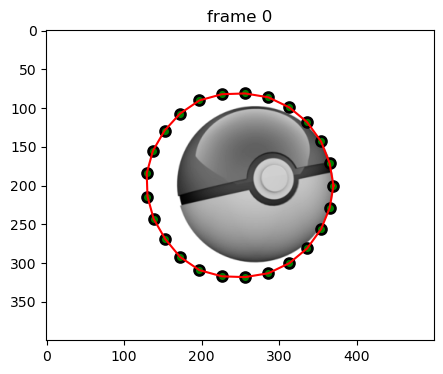

In [29]:
run('images/ball.png', radius=120)

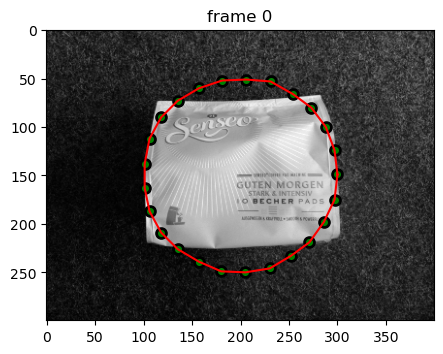

In [28]:
run('images/coffee.png', radius=100)